In [1]:
!date

Wed Dec  5 19:15:57 PST 2018


# Report Mock up

This notebook is meant to demonstrate a basic workflow when presented with a novel dataset and a need to form skillful predictions.

The report will evaluate the validity of predicting device `classification` (are the two devices related) using the available features.

### Imports and Data Prep

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets, linear_model, decomposition, metrics
from sklearn.pipeline import make_pipeline, Pipeline

Load CSV

In [3]:
device_df = pd.read_csv('device_data.csv')

In [4]:
device_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 22 columns):
Unnamed: 0             165474 non-null int64
device1                165474 non-null object
device1_numsessions    165474 non-null int64
device2                165474 non-null object
session_overlaps       165474 non-null int64
device2_numsessions    165474 non-null int64
device2_count2         165474 non-null int64
device2_count3         165474 non-null int64
device2_loc1           165474 non-null object
device2_count4         165474 non-null int64
device2_count5         165474 non-null int64
device2_date1          165474 non-null object
device2_date2          165474 non-null object
device2_bool1          59091 non-null float64
additional_feature1    165474 non-null int64
additional_feature2    165474 non-null int64
additional_feature3    165474 non-null float64
additional_feature4    165474 non-null float64
additional_feature5    165474 non-null float64
device1_date1         

Roughly 38% of the data is for connected devices, which is a fairly reasonable split. Under a more skewed distribution it would be beneficial to evaluate weighting the information, but for a first pass that doesn't seem necessary.

In [5]:
device_df['classification'].value_counts()

0    103008
1     62466
Name: classification, dtype: int64

It looks like `device2_bool1` is missing quite a bit of data. Here I make the assumption that since there are only 'true' boolean rows, the missing ones are 'false' and should be set to `0`.

In [6]:
device_df['device2_bool1'].value_counts()

1.0    59091
Name: device2_bool1, dtype: int64

In [7]:
device_df.loc[pd.isnull(device_df['device2_bool1']), 'device2_bool1'] = 0

To incorporate categorical and date information a little bit of feature engineering will be necessary. The `loc` variables will be represented by an intermediate boolean feature indicating if the location for each device was the same store or not.

Each date feature will be formated as seconds since epoch.

In [8]:
device_df[['device2_date1', 'device2_date2', 'device1_date1', 'device1_loc1', 'device2_loc1']].head()

,device2_date1,device2_date2,device1_date1,device1_loc1,device2_loc1
0,2016-10-27 11:08:05.0,2017-04-01 17:53:35.0,2016-11-26,Store_2456,Store_2456
1,2016-09-28 14:57:18.0,2017-01-24 13:59:02.0,2016-11-16,Store_2038,Store_2038
2,2016-11-25 15:45:09.0,2017-07-15 13:43:06.0,2016-12-30,Store_1947,Store_1947
3,2017-01-17 14:00:41.0,2017-03-30 12:16:00.0,2016-11-21,Store_1900,Store_1900
4,2016-10-21 18:26:57.0,2016-12-04 13:46:36.0,2016-11-20,Store_2022,Store_2022


In [9]:
device_df['loc_boolean'] = device_df['device1_loc1'] == device_df['device2_loc1']
device_df['loc_boolean'] = device_df['loc_boolean'].astype(int)

In [10]:
device_df['device2_date1_epoch'] = [time.mktime(datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S.%f").timetuple())
                                    for string_date in device_df['device2_date1'].values]
device_df['device2_date2_epoch'] = [time.mktime(datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S.%f").timetuple())
                                    for string_date in device_df['device2_date2'].values]
device_df['device1_date1_epoch'] = [time.mktime(datetime.strptime(string_date, "%Y-%m-%d").timetuple())
                                    for string_date in device_df['device1_date1'].values]

Extract feature names for array setup

In [11]:
var_list = ['session_overlaps', 'device1_numsessions', 'device2_numsessions',
            'device2_count2', 'device2_count3', 'device2_count4', 'device2_count5',
            'additional_feature1', 'additional_feature2', 'additional_feature3', 'additional_feature4',
            'additional_feature5', 'device2_date1_epoch', 'device2_date2_epoch', 'device1_date1_epoch',
            'loc_boolean', 'device2_bool1']

In [12]:
X = np.asarray(device_df.loc[:, var_list])
y = np.asarray(device_df.loc[:, ['classification']])

Scale appropriate X input features (leaving out binary columns `loc_boolean` and `device2_bool1`)

In [13]:
scaler = StandardScaler().fit(X[:, :-2])
scaled = scaler.transform(X[:, :-2])
scaled_features = np.hstack([scaled, X[:, 15:]])

Split up data for training and testing. Holding out 15% for validation.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y,
                                                    test_size=0.15,
                                                    random_state=11)

Given the binary nature of the prediction (are the two devices related) I will be utilizing logistic regression for a first pass effort. While a more complicated framework may certainly be appropriate, when it is not clear if available features will support a skillful predictive model I find it valuable to work with less complex methods. This gets results sooner and can provide support when asking for more costly implementations.

Since there are a number of available features, I will be utilizing a scikit `Pipeline` to chain a PCA decomposition with logistic regression. The plot below provides boundaries for `n_components`.

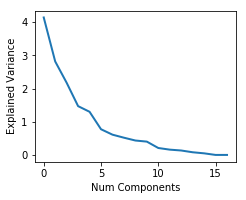

In [15]:
logistic_reg = linear_model.LogisticRegression()

pca_eval = decomposition.PCA()
pca_pipe = Pipeline(steps=[('pca', pca_eval), ('logistic', logistic_reg)])

pca_eval.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_eval.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('Num Components')
plt.ylabel('Explained Variance')

In [16]:
n_components = [10, 15]
C_s = np.logspace(-4, 4, 3)

# Use grid search to optimize component and C parameters
device_model_v1 = GridSearchCV(pca_pipe,
                               dict(pca__n_components=n_components,
                               logistic__C=C_s))
device_model_v1.fit(X_train, y_train.reshape(-1))

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [10, 15], 'logistic__C': array([  1.00000e-04,   1.00000e+00,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The logistic regression pipeline results in a model with 82.2% accuracy against the held out test data.

In [17]:
device_model_v1.score(X_test, y_test)

0.82169043590363389

## Alternative Keras Model

A relatively straightforward keras model will act as a comparison to evaluate performance lift with a more complex network.

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

Using TensorFlow backend.


Using binary crossentropy since there are only two classes to predict.

In [19]:
model = Sequential()
model.add(Dense(8, input_shape = (17, )))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 144       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


In [21]:
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)
model.fit(X_train, Y_train, verbose=1, batch_size=32, epochs=30)

Epoch 1/30
140652/140652 [==============================] - 4s - loss: 0.4218 - acc: 0.8079     
Epoch 2/30
140652/140652 [==============================] - 4s - loss: 0.3729 - acc: 0.8321     
Epoch 3/30
140652/140652 [==============================] - 3s - loss: 0.3642 - acc: 0.8366     
Epoch 4/30
140652/140652 [==============================] - 3s - loss: 0.3599 - acc: 0.8394     
Epoch 5/30
140652/140652 [==============================] - 3s - loss: 0.3573 - acc: 0.8413     
Epoch 6/30
140652/140652 [==============================] - 3s - loss: 0.3553 - acc: 0.8419     
Epoch 7/30
140652/140652 [==============================] - 3s - loss: 0.3538 - acc: 0.8434     
Epoch 8/30
140652/140652 [==============================] - 3s - loss: 0.3526 - acc: 0.8442     
Epoch 9/30
140652/140652 [==============================] - 3s - loss: 0.3516 - acc: 0.8436     
Epoch 10/30
140652/140652 [==============================] - 3s - loss: 0.3508 - acc: 0.8442     
Epoch 11/30
140652/140652 [==

In [22]:
score, accuracy = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)

24448/24822 [============================>.] - ETA: 0s

In [23]:
accuracy

0.84832003868497374

## Model Accuracy Evaluation

- Model 1 Accuracy: 81.6%
- Model 2 Accuracy: 84.9%

While raw model accuracy is certainly a valuable metric, other values must be taken into consideration when trying to determine overall performance.

Based on the above, both models appear to be decently skillful, with the keras implementation outperforming the logistic regression pipeline. To get a better understanding for the overall model performance, it is important to first determine the null accuracy (possible accuracy if the model simply predicted the most common class).

In [24]:
print('Null accuracy: {}'.format(len(device_df[device_df['classification'] == 0]) / len(device_df)))

Null accuracy: 0.6225026288117771


Both models perform far better than the null alternative (whew).

An alternative way to evaluate model classification skill beyond accuracy is to reference a confusion matrix. These tables display counts for true positives, true negatives, false positives (Type I error), and false negatives (Type II error). The boundary between the appropriate ratio of Type I to Type II errors is often highly dependent on the overall situation. In some cases it pays to be overly cautious and potentially mis-label, but in others it can be incredibly detrimental.

In [25]:
cm_model1 = metrics.confusion_matrix(y_test, device_model_v1.predict(X_test))

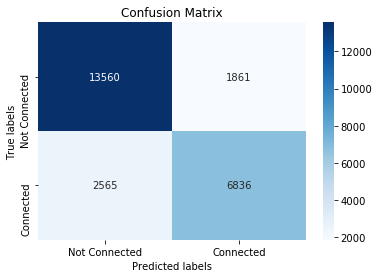

In [26]:
ax= plt.subplot()
sns.heatmap(cm_model1, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Connected', 'Connected'])
ax.yaxis.set_ticklabels(['Not Connected', 'Connected'])

In [27]:
cm_model2 = metrics.confusion_matrix(y_test, model.predict_classes(X_test))

23680/24822 [===========================>..] - ETA: 0s

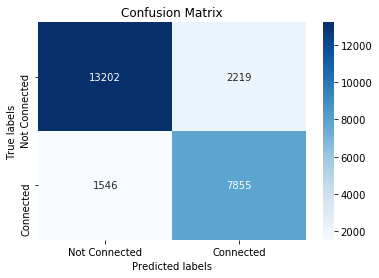

In [28]:
ax= plt.subplot()
sns.heatmap(cm_model2, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Not Connected', 'Connected'])
ax.yaxis.set_ticklabels(['Not Connected', 'Connected'])

Now we can see that the first model correctly labeled devices as 'Not Connected' at effectively the same rate as the second, more accurate model. The increase in accuracy for the second model was a result of correctly labeling many more devices as connected. However, while the second model has higher true positives and a lower rate of false negatives, the false positive rate is actually higher as well.

## Conclusion

Taking all of this into account, it would be reasonable to continue training and improving the second model as it outperforms the baseline and logistic models. If we assume that false negatives are worse than false positives, the second model is significantly more skillful, but if the opposite is true then the marginal increase in false positives may not be worth the increase in accuracy.

Save final model

In [29]:
model.save('connected_device_v2.h5')